In [37]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import tqdm
import skimage.morphology
import ipywidgets as widgets
import pytesseract

from ipywidgets import interact, interact_manual
from scipy.optimize import basinhopping
from scipy import optimize

from pathlib import Path

from IPython.display import clear_output

In [38]:
data_path = Path('data')

In [98]:
directories = [path for path in data_path.glob('*') if path.is_dir()]
dir_widget = widgets.Dropdown(
    options=directories,
    index=0,
    description="Directory:"
)
files = list([path for path in Path(dir_widget.value).rglob('*.tif') if not path.name.startswith('.')])
files_widget = widgets.Dropdown(
    options=files,
    index=0,
    description="File:"
)

    
img_file = None

@interact(a_dir=dir_widget, a_file=files_widget)
def get_img(a_dir, a_file):
    global img_file
    
    with files_widget.hold_trait_notifications():
        files = list([path for path in Path(dir_widget.value).rglob('*.tif') if not path.name.startswith('.')])
        files = set(files)
        
        print(len(files))
        if len(files.difference(set(files_widget.options))) > 0:
            files_widget.options = files
        
    img_file = cv2.imread(a_file.as_posix())[..., ::-1]
    plt.figure(figsize=(18.6, 18.6))
    plt.imshow(img_file)
    print(a_file)

interactive(children=(Dropdown(description='Directory:', options=(PosixPath('data/F4'), PosixPath('data/F0')),…

In [101]:
"""
We know that the lower half of the image has a marked area which is the most uniform in values.
Thus, expect that the variance between colored area and marked area will be the hightes and 
points the best split point.
"""

def get_halves(cut_index):
    cut_img = img_file[:-cut_index]
    split_point = cut_img.shape[0] // 2
    up = cut_img[:split_point]
    low = cut_img[split_point:]
    return low, up

def get_var_map(low, up):
    diff = np.abs(low - up)
    variance = np.var(diff, axis=-1)
    var_img = (variance > 2005).astype(np.uint8) * 255
    var_img = cv2.medianBlur(var_img, 5)
    return var_img


def calc_split(cut_index):
    return np.sum(get_var_map(*get_halves(cut_index)))

low, up = None, None

@interact_manual()
def get_lower_upper_halves():
    global low, up
    height, width = img_file.shape[:-1]
    best_cut_quality = -np.inf
    best_cut_index = 1 if height % 2 != 0 else 2
    qualities = []
    for i in range(best_cut_index, (height - 1) // 8, 2):
        cur_quality = calc_split(i)
        qualities.append((i, cur_quality))
        if cur_quality > best_cut_quality:
            best_cut_quality = cur_quality
            best_cut_index = i
            
    plt.figure()
    plt.plot(*list(zip(*qualities)))
    plt.show()
    print("Best cut at: {}".format(best_cut_index))
    low, up = get_halves(best_cut_index)
    
    f, ax = plt.subplots(1, 2, sharex=True, figsize=(18.2, 9.6))
    plt.tight_layout()
    ax[0].imshow(low)
    ax[1].imshow(up)
    plt.show()

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [100]:
margin_widget = widgets.IntSlider(
    min=0,
    max=20,
    value=10,
    description="Border margin in px:"
)

rectangle_params = []
cut_area = None

@interact_manual(margin=margin_widget)
def get_rectanglish_area(margin):
    global rectangle_params, cut_area
    
    var_img = get_var_map(low, up)
    cnt = cv2.findContours(var_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = [(c, cv2.contourArea(c)) for c in cnt[1]]

    max_contour = max(contours, key=lambda x: x[1])[0]
    
    bbox = cv2.boundingRect(max_contour)
    
    y = bbox[1] - margin
    h = bbox[3] + margin * 2
    
    x = bbox[0] - margin
    w = bbox[2] + margin * 2
    
    cut_area = low[y:y+h, x:x+w]
    
    rectangle_params = [
        x, y, w, h
    ]
    
    plt.figure(figsize=(9.6, 9.6))
    plt.imshow(cut_area)
    plt.show()

interactive(children=(IntSlider(value=10, description='Border margin in px:', max=20), Button(description='Run…

In [102]:
circle_params = []

@interact_manual()
def get_circle():
    global circle_params
    
    gray = cv2.cvtColor(cut_area, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray,cv2.CV_64F)
    laplacian = 1 - laplacian / laplacian.max()
    
    
    f = np.fft.fft2(laplacian)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    mask = magnitude_spectrum > np.percentile(magnitude_spectrum, 99)
    
    fshift[mask] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift).real
    img_back = np.abs(img_back)
    
    f = np.fft.fft2(img_back)
    fshift = np.fft.fftshift(f)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.abs(img_back)
    
    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())
    img_back = (img_back > 0.5).astype(np.uint8)

    # minimzed function
    def function_to_minimize(params, *args):
        """
        Function takes params of a circle and matches to to current img. It does so by
        making 4px wide border around the circle and then taking intersection of predicted
        mask and those found in the `img_back`. 
        params:
            params: params to minimze (x_center, y_center, radius) of the circle
        returns:
            Scalar value of degree which mask and circle matches.
        """
        height, width = args
        clear_output(wait=True)
        params = [int(val) for val in params]
        x_center, y_center, radius = params
        predicted = np.zeros_like(img_back).astype(np.uint8)
        cv2.circle(predicted, (x_center, y_center), radius, 255, 1)
        predicted //= 255
        
        penalty = 0
        condition = (
            x_center + radius >= width
            or x_center - radius < 0
            or y_center + radius >= height
            or y_center - radius < 0 
        )
        if condition:
            penalty = + 1e8

        fitness_value = np.sum((predicted > 0) & (img_back > 0))
        print("Fitness: {:.4f}".format(fitness_value))

        return -fitness_value + penalty

    ret = optimize.differential_evolution(
        function_to_minimize,
        bounds=[(0, img_back.shape[1]),
                (0, img_back.shape[0]),
                (0, max(img_back.shape[0] // 2, img_back.shape[1] // 2))],
        args=(img_back.shape[0], img_back.shape[1]),
        maxiter=1000,
        popsize=15,
        tol=0.001
    )

    result = np.zeros_like(img_back).astype(np.uint8)
    x_center, y_center, radius = [int(val) for val in ret.x]
    cv2.circle(result, (x_center, y_center), radius, 255, 1)

    f, ax = plt.subplots(1, 3, figsize=(4.8 * 3, 4.8), sharey=True)
    plt.tight_layout()
    f.subplots_adjust(wspace=0)
    ax[0].imshow(result, cmap="gray")
    ax[1].imshow(img_back, cmap="gray")
    ax[2].imshow(gray, cmap="gray")
    
    circle_params = [
        rectangle_params[0] + x_center,
        rectangle_params[1] + y_center,
        radius
    ]

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [103]:
"""
Those values can be calculated once for all images since all upper
halves are consistent with each other with respect to annotation
location.
"""
left_point, right_point = 130, 870
legend_vertical_point = 177
legend_horizontal_point = 153

left_side, right_side, lower_right_side, upper_right_side, legend_bar, legend_bar_text = [None] * 6

@interact_manual()
def get_left_right_points():
    global left_side, right_side, lower_right_side, upper_right_side, legend_bar, legend_bar_text
    left_side = up[:, :left_point]
    right_side = up[:, right_point:]

    lower_right_side = right_side[legend_vertical_point:]
    upper_right_side = right_side[:legend_vertical_point]

    legend_bar = upper_right_side[:, :legend_horizontal_point]
    legend_bar_text = upper_right_side[:, legend_horizontal_point:]

    print(f"Left point: {left_point}")
    print(f"Right point: {right_point}")
    print(f"Legend vertical point: {legend_vertical_point}")
    print(f"Legend horizontal point: {legend_horizontal_point}")
    print("Found according to sum of values in y axis:")
    a_sum = np.sum(np.sum(up, axis=-1), axis=0)
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(9.6, 8))
    plt.tight_layout()
    f.subplots_adjust(hspace=0)
    plt.xticks(np.arange(0, len(a_sum), 50))
    
    ax[0].plot(list(range(up.shape[1])), a_sum)
    ax[0].yaxis.set_visible(False)
    ax[1].imshow(up)
    ax[1].yaxis.set_visible(False)
    plt.show()
    
    f, ax = plt.subplots(1, 2, sharey=True)
    plt.tight_layout()
    f.subplots_adjust(wspace=0)
    ax[0].imshow(left_side)
    ax[0].axis('off')
    ax[1].imshow(right_side)
    ax[1].axis('off')
    plt.show()
    
    right_side_sum = right_side.sum(axis=-1).sum(axis=1)
    f, ax = plt.subplots(1, 2, sharey=True)
    plt.tight_layout()
    f.subplots_adjust(wspace=0)
    ax[0].plot(right_side_sum, list(range(len(right_side_sum))))
    ax[0].xaxis.tick_top()
    ax[0].set_ylim(len(right_side_sum), 0)
    
    ax[1].imshow(right_side)
    ax[1].yaxis.set_visible(False)
    plt.show()
    
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(2.4, 4.8))
    plt.tight_layout()
    f.subplots_adjust(hspace=0)
    ax[0].plot(list(range(upper_right_side.shape[1])), upper_right_side.sum(axis=-1).sum(axis=0))
    ax[1].imshow(upper_right_side)
    plt.show()
    
    
    f, ax = plt.subplots(1, 3, sharey=True)
    ax[0].imshow(legend_bar)
    ax[1].imshow(legend_bar_text)
    ax[2].imshow(lower_right_side)
    plt.show()
    

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [105]:
config = "-l eng --oem 1 --psm 6"
left_side_annotation = ""
legend_bar_annotation = ""
lower_right_annotation = ""
def get_text_for_img(an_img, relative_x, relative_y):
    height, width = an_img.shape[:-1]
    gray = cv2.cvtColor(an_img, cv2.COLOR_RGB2GRAY)
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    skeleton = skimage.morphology.skeletonize(gray // 255).astype(np.uint8) * 255
    text_blocks = skeleton.copy()
    
    text_blocks[:] = skeleton.max(axis=1, keepdims=True)


    _, cnts, _ = cv2.findContours(text_blocks, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    lines = []
    
    for cnt in cnts:
        x_min = max(np.min(cnt[..., 0]) - 3, 0)
        x_max = min(np.max(cnt[..., 0]) + 3, width)
        y_min = max(np.min(cnt[..., 1]) - 3, 0)
        y_max = min(np.max(cnt[..., 1]) + 3, height)
        cut = an_img[y_min:y_max, x_min:x_max]
        lines.append((cut, (x_min, y_min, x_max - x_min, y_max - y_min)))
    
    text_with_coordinates = []
    
    for i, line in enumerate(lines):
        line_img, line_coords = line
        cut = cv2.cvtColor(line_img, cv2.COLOR_RGB2GRAY)
        cut = cv2.resize(cut, None, fx=4, fy=4, interpolation=cv2.INTER_LANCZOS4)
        cut = 255 - (cut > 127).astype(np.uint8) * 255
        text = pytesseract.image_to_string(cut, config=config)
        text = text.replace('—', '').replace('-', '').replace('~', '').strip()
        
        x, y, w, h = line_coords
        text_with_coordinates.append(
            (text, (x + relative_x, y + relative_y, w, h))
        )
        
    text_with_coordinates = list(sorted(text_with_coordinates, key=lambda x: x[1][1]))
    
    return text_with_coordinates

@interact_manual()
def get_annotations():
    def join_texts(data):
        return '\n'.join([elem[0] for elem in data])
    
    
    global left_side_annotation, legend_bar_annotation, lower_right_annotation
    left_side_annotation_data = get_text_for_img(left_side, 0, 0)
    legend_bar_annotation_data = get_text_for_img(legend_bar_text, right_point + legend_horizontal_point, 0)
    lower_right_annotation_data = get_text_for_img(lower_right_side, right_point + legend_horizontal_point, legend_vertical_point)
    
    left_side_annotation = join_texts(left_side_annotation_data)
    legend_bar_annotation = join_texts(legend_bar_annotation_data)
    lower_right_annotation = join_texts(lower_right_annotation_data)
    
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(left_side)
    ax[0].set_xlabel(left_side_annotation)
    
    ax[1].imshow(legend_bar_text)
    ax[1].set_xlabel(legend_bar_annotation)
    
    ax[2].imshow(lower_right_side)
    ax[2].set_xlabel(lower_right_annotation)
    
    plt.show()

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

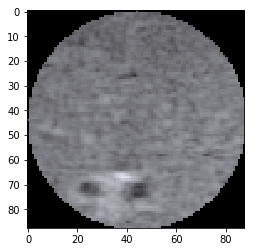

In [106]:
mask = np.zeros(low.shape[:-1]).astype(np.uint8)
height, width = mask.shape
x_center, y_center, radius = circle_params
radius -= 2
cv2.circle(mask, (x_center, y_center), radius, 255, -1)
x_min = max(x_center - radius, 0)
x_max = min(x_center + radius, width)
y_min = max(y_center - radius, 0)
y_max = min(y_center + radius, height)

mask = mask == 255
kek = low.copy()
kek[~mask] = 0
kek = kek[y_min:y_max, x_min:x_max]

plt.imshow(kek)

In [95]:
from scipy.stats import rv_continuous
from scipy.special import gamma as gamma_fn
from collections.abc import Iterable
import numpy as np

class generalized_gamma_gen(rv_continuous):
    def _pdf(self, x, delta, beta, rho):
        if isinstance(x, Iterable):
            mask = x <= 0
            result = np.zeros_like(x)

            x = x[~mask]
            delta = delta[~mask]
            beta = beta[~mask]
            rho = rho[~mask]
            result[~mask] = (
                delta / (beta ** (rho * delta) * gamma_fn(rho))
                * x ** (rho * delta - 1)  * np.exp(
                    - (x / beta) ** delta
                )
            )
        else:
            result = (
                delta / (beta ** (rho * delta) * gamma_fn(rho))
                * x ** (rho * delta - 1)  * np.exp(
                    - (x / beta) ** delta
                )
            )
        return result 

generalized_gamma = generalized_gamma_gen(name="generalized_gamma")

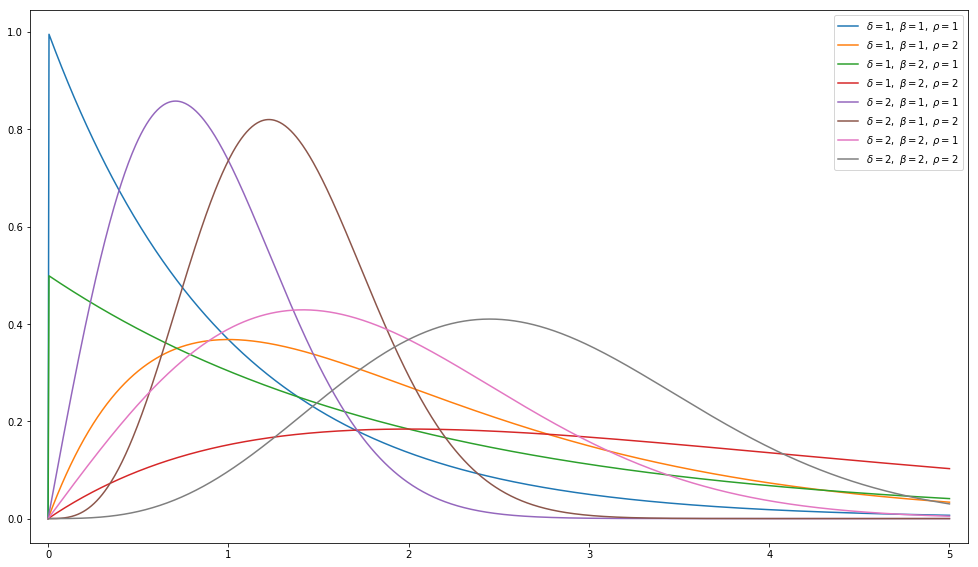

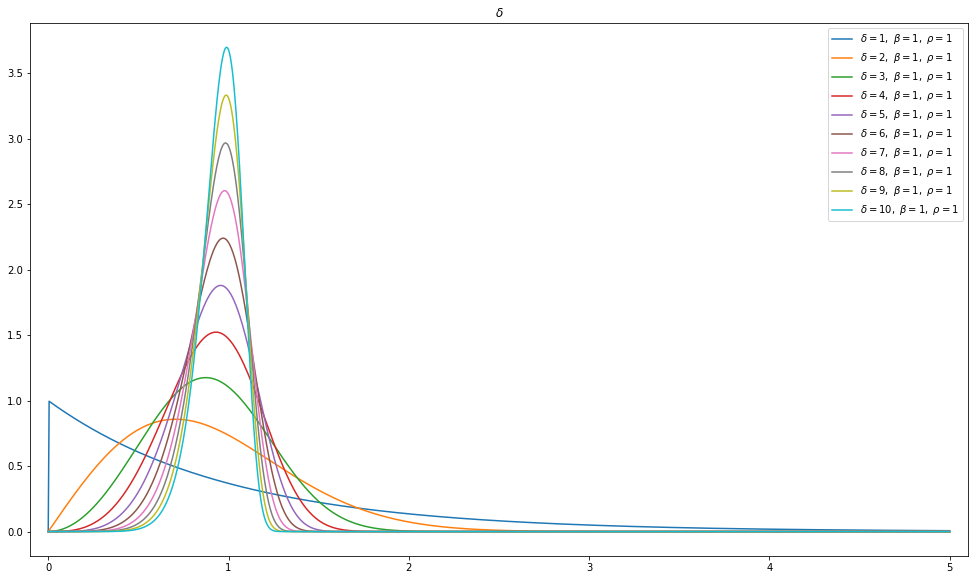

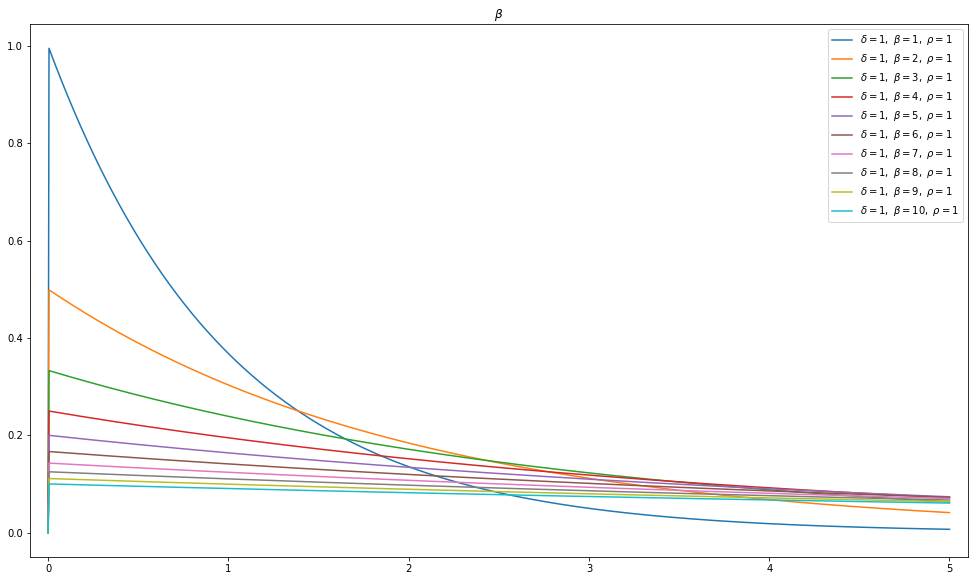

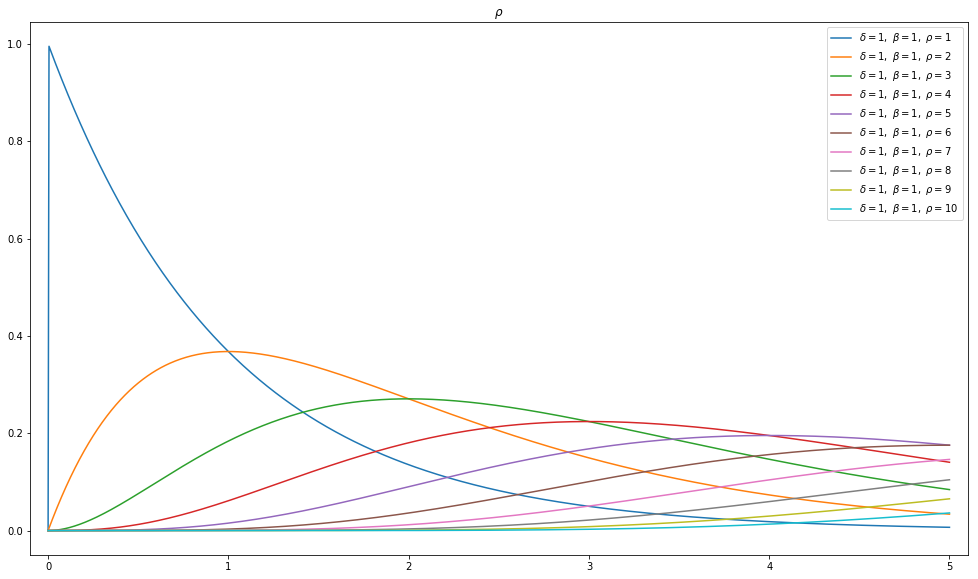

In [96]:
import itertools

delta_values = [1, 2]
beta_values = [1, 2]
rho_values = [1, 2]
plt.figure(figsize=(16.8, 9.8))

params = list(itertools.product(delta_values, beta_values, rho_values))
xs = np.linspace(0, 5, 1000)
for delta, beta, rho in params:
    name = "$\\delta = {}, \\ \\beta = {}, \\ \\rho = {}$".format(
        delta, beta, rho
    )
    
    pdf = generalized_gamma.pdf(xs, delta, beta, rho)
    plt.plot(xs, pdf, label=name)
    plt.xlim(-0.1, 5.1)
plt.legend(loc="best")
plt.show()

const_delta = 1
const_beta = 1
const_rho = 1

possible_deltas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
possible_betas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
possible_rhos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.figure(figsize=(16.8, 9.8))
for delta in possible_deltas:
    name = "$\\delta = {}, \\ \\beta = {}, \\ \\rho = {}$".format(
        delta, const_beta, const_rho
    )
    
    pdf = generalized_gamma.pdf(xs, delta, const_beta, const_rho)
    plt.title("$\\delta$")
    plt.plot(xs, pdf, label=name)
    plt.xlim(-0.1, 5.1)
plt.legend(loc="best")
plt.show()


plt.figure(figsize=(16.8, 9.8))
for beta in possible_betas:
    name = "$\\delta = {}, \\ \\beta = {}, \\ \\rho = {}$".format(
        const_delta, beta, const_rho
    )
    
    pdf = generalized_gamma.pdf(xs, const_delta, beta, const_rho)
    plt.title("$\\beta$")
    plt.plot(xs, pdf, label=name)
    plt.xlim(-0.1, 5.1)
plt.legend(loc="best")
plt.show()


plt.figure(figsize=(16.8, 9.8))
for rho in possible_rhos:
    name = "$\\delta = {}, \\ \\beta = {}, \\ \\rho = {}$".format(
        const_delta, const_beta, rho
    )
    
    pdf = generalized_gamma.pdf(xs, const_delta, const_beta, rho)
    plt.title("$\\rho$")
    plt.plot(xs, pdf, label=name)
    plt.xlim(-0.1, 5.1)
plt.legend(loc="best")
plt.show()





In [97]:
xx = np.zeros((512, 512))
noise = generalized_gamma.rvs(delta=2, beta=1, rho=2)

OverflowError: (34, 'Numerical result out of range')

### Versions:

- tesseract beta1 v4.0.0 - got by using `sudo apt install tesseract-ocr && sudo apt install libtesseract-dev`
- the rest: